In [1]:
import sys
# sys.path.append('/cluster/home/taoj/work_dir/eth-capstone/tree-water-deficit/eth-capstone-treewater-deficit/src')
sys.path.append('/workspaces/eth-capstone-treewater-deficit/src')
import os
import glob 

import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import scipy as sc

import plotly.express as px
import plotly.graph_objects as go

import collections

from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.ar_model import AutoReg
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.model_selection import train_test_split
from sklearn.metrics import root_mean_squared_error, r2_score

import tensorflow as tf
from tensorflow import keras as tf_keras

from sklearn.preprocessing import StandardScaler
from treewater.utils import *

2025-11-30 13:13:52.188131: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2025-11-30 13:14:14.408686: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-11-30 13:14:23.057570: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.


In [2]:
# ...existing code...
def cross_validate_datasets(train_df, n_splits=4, feature_window_size=13, config=None):
    """Create cross validation datasets for time series data.
    
    Args:
        train_df (pd.DataFrame): The training dataframe containing time series data.
        n_splits (int): Number of splits for cross-validation.
    
    Returns:
        List of tuples: Each tuple contains (train_split, val_split) dataframes.
    """
    from sklearn.model_selection import TimeSeriesSplit
    TimeSeriesSplitCls = TimeSeriesSplit

    sites = train_df['site_name'].unique()
    train_val_datasets = []
    # collect raw (unstandardized) per-fold DataFrame pieces
    train_datasets = {}
    val_datasets = {}

    for site in sites:
        df_site = train_df.loc[train_df['site_name'] == site, ]
        species = df_site['species'].unique()

        for sp in species:
            df_sp = (
                df_site.loc[df_site['species'] == sp, ]
                .sort_values(by='ts', ascending=True)
                .reset_index(drop=True)
            )

            m = len(df_sp)
            if m <= 1:
                # too small: add group's raw rows to every fold's training (no val rows)
                for f in range(n_splits):
                    train_datasets.setdefault(f, []).append(df_sp)
                continue

            splits_for_group = min(n_splits, max(1, m - 1))
            tscv_group = TimeSeriesSplitCls(n_splits=splits_for_group)

            for i, (train_index, test_index) in enumerate(tscv_group.split(df_sp)):
                train_split = df_sp.iloc[train_index]

                # expand validation window backward by feature_window_size to allow window construction
                val_start = max(0, test_index[0] - feature_window_size)
                val_end = test_index[-1] + 1  # exclusive stop for iloc slicing
                val_split = df_sp.iloc[val_start:val_end]

                # append raw splits; standardize once per fold after concatenation
                train_datasets.setdefault(i, []).append(train_split)
                val_datasets.setdefault(i, []).append(val_split)

            # if this group produced fewer folds than n_splits, add group's full raw training to remaining folds
            if splits_for_group < n_splits:
                for f in range(splits_for_group, n_splits):
                    train_datasets.setdefault(f, []).append(df_sp)

    # build final per-fold DataFrames and standardize once per fold
    for f in range(n_splits):
        if f not in val_datasets or len(val_datasets[f]) == 0:
            # nothing to validate in this fold -> skip
            continue

        train_fold_df = pd.concat(train_datasets.get(f, []), ignore_index=True).reset_index(drop=True)
        val_fold_df = pd.concat(val_datasets[f], ignore_index=True).reset_index(drop=True)

        # standardize concatenated fold-level splits once
        train_cv_df, val_cv_df, _ = standardize_dataset(train_fold_df, val_fold_df, val_fold_df, config=config)
        train_val_datasets.append((train_cv_df, val_cv_df))
    

    return train_val_datasets

# def cross_validate_datasets(train_df, n_splits=4, feature_window_size=13, config=None):
#     """Create CV datasets by splitting each (site, species, series) time series independently
#     and concatenating group-level folds into global per-fold train/val DataFrames.
#     Returns list of (train_cv_df, val_cv_df).
#     """
#     from sklearn.model_selection import TimeSeriesSplit

#     # grouping keys to split per series/site/species
#     group_cols = [c for c in ("site_name", "species") if c in train_df.columns]
#     if not group_cols:
#         # fallback to global split
#         tscv = TimeSeriesSplit(n_splits=n_splits)
#         out = []
#         for _, (train_idx, test_idx) in enumerate(tscv.split(train_df)):
#             train_split = train_df.iloc[train_idx]
#             val_start = max(0, test_idx[0] - feature_window_size)
#             val_idx = np.arange(val_start, test_idx[-1] + 1)
#             val_split = train_df.iloc[val_idx]
#             train_cv_df, val_cv_df, _ = standardize_dataset(train_split, val_split, val_split, config=config)
#             out.append((train_cv_df, val_cv_df))
#         return out

#     # accumulate per-fold lists of group-level DataFrames
#     train_datasets = {f: [] for f in range(n_splits)}
#     val_datasets = {f: [] for f in range(n_splits)}

#     for _, g in train_df.groupby(group_cols):
#         g = g.sort_values("ts", ascending=True).reset_index(drop=True)
#         m = len(g)
#         if m <= 1:
#             # too small: standardize whole group once and add to every fold's training
#             train_full, _, _ = standardize_dataset(g, g, g, config=config)
#             for f in range(n_splits):
#                 train_datasets[f].append(train_full)
#             continue

#         # choose splits for this group (TimeSeriesSplit requires n_splits <= n_samples-1)
#         splits_for_group = min(n_splits, max(1, m - 1))
#         tscv_group = TimeSeriesSplit(n_splits=splits_for_group)

#         # keep group's full standardized train for assigning to later folds if needed
#         train_full = None

#         for f_rel, (train_idx, test_idx) in enumerate(tscv_group.split(g)):
#             # expand validation window backward by feature_window_size to allow window construction
#             val_start = max(0, test_idx[0] - feature_window_size)
#             val_idx = np.arange(val_start, test_idx[-1] + 1)

#             train_split = g.iloc[train_idx]
#             val_split = g.iloc[val_idx]

#             train_cv_df, val_cv_df, _ = standardize_dataset(train_split, val_split, val_split, config=config)
#             train_datasets[f_rel].append(train_cv_df)
#             val_datasets[f_rel].append(val_cv_df)

#             if train_full is None:
#                 train_full, _, _ = standardize_dataset(g, g, g, config=config)

#         # if this group produced fewer folds than n_splits, assign its full training to remaining folds
#         if splits_for_group < n_splits:
#             for f in range(splits_for_group, n_splits):
#                 train_datasets[f].append(train_full)

#     # build final per-fold DataFrames (skip folds with no validation rows)
#     train_val_datasets = []
#     for f in range(n_splits):
#         if len(val_datasets[f]) == 0:
#             # nothing to validate in this fold
#             continue
#         train_fold_df = pd.concat(train_datasets[f], ignore_index=True).reset_index(drop=True)
#         val_fold_df = pd.concat(val_datasets[f], ignore_index=True).reset_index(drop=True)

#         # re-standardize the concatenated fold-level splits to ensure consistent scaling
#         train_cv_df, val_cv_df, _ = standardize_dataset(train_fold_df, val_fold_df, val_fold_df, config=config)
#         train_val_datasets.append((train_cv_df, val_cv_df))

#     return train_val_datasets
# # ...existing code...


def build_ds_from_get_dataset_LSTM(df_split, feature_window_size, config,
                                   autoregressive=True, shift=1, batch_size=64):
    """Build a tf.data.Dataset from the 3-input output of get_dataset_LSTM.
    Robustly handles outputs that are already tf.Tensors (EagerTensor) or numpy-like.
    """
    X_ts, day_feat, static_X, y = get_dataset_LSTM(
        df_split,
        feature_window_size=feature_window_size,
        label_window_size=1,
        autoregressive=autoregressive,
        shift=shift,
        config=config,
    )


    ds = tf.data.Dataset.from_tensor_slices(((X_ts, day_feat, static_X), y))
    ds = ds.batch(batch_size).prefetch(tf.data.AUTOTUNE)
    return ds



In [3]:
# # At top of notebook
# %load_ext autoreload
# %autoreload 2

# from treewater.utils import *

In [4]:
# derived_path = "/cluster/home/taoj/work_dir/eth-capstone/tree-water-deficit/data"
# data_dir = "/cluster/home/taoj/work_dir/eth-caipstone/tree-water-deficit/data/tstoy04"
data_dir = "/workspaces/eth-capstone-treewater-deficit/data/tstoy04"
derived_path = "/workspaces/eth-capstone-treewater-deficit/data"

In [5]:
df_series_all = pd.read_csv(os.path.join(derived_path, "twd_tree_series_all.csv"))
twd_tree_series_sites = pd.read_csv(os.path.join(derived_path, "twd_tree_series_sites.csv"))

In [6]:
df_series_all.head(5)
# twd_tree_series_sites.head(10)

,ts,twd,pr,at,ws,dp,sr,lr,series,site_name,species,series_no,Wt,year,month,year_month
0,2020-01-01,0.000000,-4.967054e-09,0.684757,1.197186,-3.640214,62.291590,212.325577,series_03,Bachtel-Forest,Fagus sylvatica,1,NaN,2020,1,2020-01
1,2020-01-02,0.121408,-1.092752e-07,0.213088,1.312338,-4.036302,60.923900,219.828021,series_03,Bachtel-Forest,Fagus sylvatica,1,0.121408,2020,1,2020-01
2,2020-01-03,0.118271,1.285767e-01,2.009851,2.115951,-0.953911,55.859708,275.925156,series_03,Bachtel-Forest,Fagus sylvatica,1,-0.003137,2020,1,2020-01
3,2020-01-04,0.000000,9.927122e-02,1.573278,3.247398,0.721803,13.914832,311.878969,series_03,Bachtel-Forest,Fagus sylvatica,1,-0.118271,2020,1,2020-01
4,2020-01-05,0.000000,-1.986821e-08,-0.442240,2.159941,-4.094125,62.620516,216.038632,series_03,Bachtel-Forest,Fagus sylvatica,1,0.000000,2020,1,2020-01


## data preparation

In [7]:
# test if in the same day same site, temp and other features are the same

sites = df_series_all['site_name'].unique()
for site in sites:
    df_site = df_series_all.loc[df_series_all.site_name == site, ]
    series = df_site.series_no.unique()
    if len(series) >=2:
        series_1 = df_site.loc[df_site.series_no == series[0], ]
        series_2 = df_site.loc[df_site.series_no == series[1], ]
        merged = pd.merge(series_1, series_2, on='ts', suffixes=('_1', '_2'))
        temp_equal = all(merged['at_1'] == merged['at_2'])
        pr_equal = all(merged['pr_1'] == merged['pr_2'])
        dp_equal = all(merged['dp_1'] == merged['dp_2'])
        sr_equal = all(merged['sr_1'] == merged['sr_2'])
        if not (temp_equal and pr_equal and dp_equal and sr_equal):
            print(f"Data mismatch found in site {site} between series {series[0]} and {series[1]}")

# so far they are no mismatch found, all the other measurements are the same for different series in the same site


In [8]:
# twd_tree_series_sites

In [9]:
# Psudotsuga mnzisii", from site "Multi-Forest" in 2021, 2022 exluded
df_series_all = df_series_all.loc[~((df_series_all.species == "Psudotsuga mnzisii") & (df_series_all.site_name == "Multi-Forest") & (df_series_all.year.isin([2021, 2022]))), ]
df_series_all_median = df_series_all.groupby(['site_name', 'species', 'ts']).agg({'twd': 'median',  'year': 'first',
                                                                                 'pr': 'median', 'at': 'median', "ws": 'median', 'dp': 'median',
                                                                                 'sr': 'median', 'lr':'median'}).reset_index() 

df_series_all_median= df_series_all_median.merge(twd_tree_series_sites[['site_name', 'species', 'mch_elevation', "mch_easting",
                                                                        "mch_northing"]].drop_duplicates(), on=['site_name', 'species'], how='left')

In [10]:
# transform species to categorical variable - using ohe-hot encoding
# Get one hot encoding of columns B
one_hot = pd.get_dummies(df_series_all_median['species'],dtype=float)
# Drop column B as it is now encoded, hmm maybe not yet
df_series_all_features = df_series_all_median
# Join the encoded df
df_series_all_features = df_series_all_features.join(one_hot.iloc[: , 0:6])
# drop useless features 
df_series_features = df_series_all_features.drop(columns=['year'])

In [11]:
# create a dataframe with log2 transformed twd values
df_series_features_log2 = df_series_features.copy()
epsilon = 1e-6
df_series_features_log2['twd'] = np.log2(epsilon+ df_series_features_log2['twd'])

split the data into training and test set
 - train and test set split by an even distribution of sites? 
 - easting and northing recommended
 - if autoregressive with lag =13
    - label: twd_t
    - input feature: [twd_t-12, twd_t-11, ...twd_t-1, at_t-1, lt_t-1]? 
    - can i use at_t as input feature?


Normalize certain colums: 

- pr	at	ws	dp	sr	lr	mch_elevation	site_longitude	site_latitude
- if twd was treated as feature should we then standardize it when model is autoregressive? 
- should we normalize it before or after splitting by windows? - i guess really no harm either way 

In [12]:
# Configure features
config = FeatureConfig()
lag_n =13

# Autoregressive
# Split data
train_df_at, val_df_at, test_df_at = create_training_test_set_optimized(
    df_series_features,
    feature_window_size=lag_n,
    autoregressive=True
)

train_df_at, val_df_at, test_df_at = standardize_dataset(
    train_df_at, val_df_at, test_df_at,
    config
)

# Create windows
train_X_ts_at, train_day_feat_X_at, train_static_X_ts_at,  train_y_at = get_dataset_LSTM(
    train_df_at,
    feature_window_size=lag_n,
    label_window_size = 1,
    autoregressive=True,
    shift = 1,
    config=config
)

val_X_ts_at, val_day_feat_X_at, val_static_X_ts_at, val_y_at = get_dataset_LSTM(
    val_df_at,
    feature_window_size=lag_n,
    label_window_size = 1,
    autoregressive=True,
    shift = 1,
    config=config
)




# # non-autoregressive

# Split data
train_df, val_df, test_df = create_training_test_set_optimized(
    df_series_features,
    feature_window_size=lag_n,
    autoregressive=False
)

train_df, val_df, test_df = standardize_dataset(
    train_df_at, val_df_at, test_df_at,
    config
)

# Create windows
train_X_ts, train_day_feat_X, train_static_X_ts,  train_y = get_dataset_LSTM(
    train_df_at,
    feature_window_size=lag_n,
    label_window_size = 1,
    autoregressive=False,
    shift = 1,
    config=config
)

val_X_ts, val_day_feat_X, val_static_X_ts, val_y = get_dataset_LSTM(
    val_df_at,
    feature_window_size=lag_n,
    label_window_size = 1,
    autoregressive=False,
    shift = 1,
    config=config
)







2025-11-30 13:14:25.718233: E external/local_xla/xla/stream_executor/cuda/cuda_platform.cc:51] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


### build LSTM
- LSTM 
- RNN
- and perhaps try elastic net to improve ridgeregression model performance, and try gaussian regressor

In [13]:

batch_size = 64
lag_n = 13

### Non-autoregressive

In [14]:
train_X_ts.shape
# input for LSTM A 3D tensor, with shape (batch, timesteps, feature).

TensorShape([15060, 13, 6])

In [15]:
# dynamic input
timesteps = lag_n
n_features = train_X_ts.shape[2] # include TWD + other variables

dyn_in = tf_keras.layers.Input(shape=(timesteps, n_features), name="past_dynamic")

x_dyn = tf_keras.layers.LSTM(16, return_sequences=False)(dyn_in)
x_dyn = tf_keras.layers.Dense(16, activation="relu")(x_dyn)


# current day other features
n_static = train_day_feat_X.shape[1]
static_in = tf_keras.Input(shape=(n_static,), name="current_day_exog")
x_static = tf_keras.layers.Dense(4, 
                                 activation="relu",
                                 kernel_regularizer=tf.keras.regularizers.l2(1e-3),
                                 )(static_in)


# static input
n_current = train_static_X_ts.shape[1]
curr_in = tf_keras.Input(shape=(n_current,), name="static")
x_curr = tf_keras.layers.Dense(4, 
                               activation="relu",
                               kernel_regularizer=tf.keras.regularizers.l2(1e-3),
                               )(curr_in)



combined = tf_keras.layers.Concatenate()([x_dyn, x_static, x_curr])
x = tf_keras.layers.Dense(16, activation="relu")(combined)
out = tf_keras.layers.Dense(1, activation="softplus")(x)


model = tf_keras.Model(
    inputs=[dyn_in, static_in, curr_in],
    outputs=out,
)

model.compile(
    optimizer=tf_keras.optimizers.Adam(),
    loss="mse",
    metrics=[
        tf_keras.metrics.RootMeanSquaredError(name="rmse"),
        tf_keras.metrics.MeanAbsoluteError(name="mae"),
    ],
)

In [16]:
# building datasets
batch_size = batch_size

train_ds = tf.data.Dataset.from_tensor_slices((
    (train_X_ts, train_day_feat_X, train_static_X_ts),
    train_y,
))
train_ds = (
    train_ds
    .shuffle(buffer_size=len(train_X_ts))
    .batch(batch_size)
    .prefetch(tf.data.AUTOTUNE)
)

val_ds = tf.data.Dataset.from_tensor_slices((
    (val_X_ts, val_day_feat_X, val_static_X_ts),
    val_y,
))
val_ds = (
    val_ds
    .batch(batch_size)
    .prefetch(tf.data.AUTOTUNE)
)


# # create cv datasets
# train_val_datasets = cross_validate_datasets(
#     train_df,
#     n_splits=4,
#     feature_window_size=lag_n,
#     config=config
# )   



In [17]:
history = model.fit(
    train_ds,
    epochs=50,
    validation_data=val_ds,
)


Epoch 1/50


236/236 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - loss: 0.5714 - mae: 0.5386 - rmse: 0.7500 - val_loss: 0.4513 - val_mae: 0.4776 - val_rmse: 0.6656
Epoch 2/50
236/236 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.4520 - mae: 0.4697 - rmse: 0.6664 - val_loss: 0.4267 - val_mae: 0.4629 - val_rmse: 0.6473
Epoch 3/50
236/236 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.4085 - mae: 0.4495 - rmse: 0.6332 - val_loss: 0.3952 - val_mae: 0.4642 - val_rmse: 0.6227
Epoch 4/50
236/236 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.3809 - mae: 0.4351 - rmse: 0.6111 - val_loss: 0.3847 - val_mae: 0.4519 - val_rmse: 0.6141
Epoch 5/50
236/236 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.3573 - mae: 0.4206 - rmse: 0.5912 - val_loss: 0.4011 - val_mae: 0.4610 - val_rmse: 0.6271
Epoch 6/50
236/236 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.3410 - mae: 0.4108 - rmse: 0.5770 - val_loss: 0.3887 - val_mae: 0.4315 - val_rmse: 0.6168
Epoch 7/50
236/236 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.3247 - mae: 0.4003 - rmse: 0.5625 - v

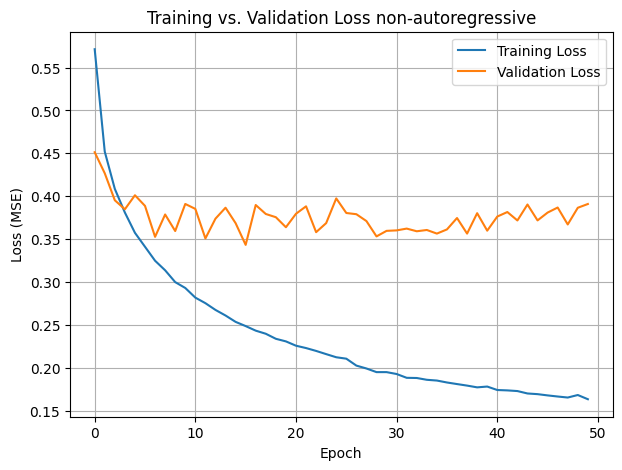

51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
rmse: 0.620521, r2: 0.371440 


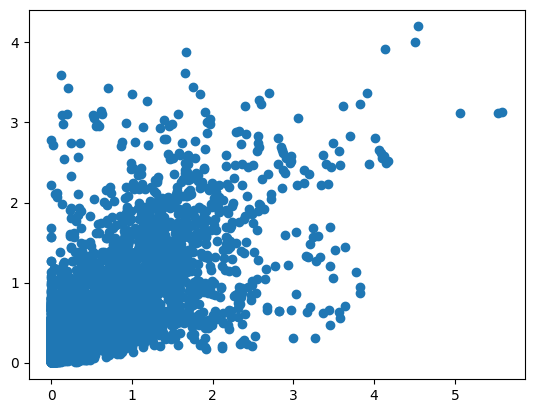

In [18]:


# Extract loss values
train_loss= history.history["loss"]
val_loss = history.history["val_loss"]

# Plot
plt.figure(figsize=(7, 5))
plt.plot(train_loss, label="Training Loss")
plt.plot(val_loss, label="Validation Loss")
plt.title("Training vs. Validation Loss non-autoregressive")
plt.xlabel("Epoch")
plt.ylabel("Loss (MSE)")
plt.legend()
plt.grid(True)
plt.show()




y_pred_val_1day= model.predict(val_ds)# show first few predictions

rmse_1day = root_mean_squared_error(y_pred_val_1day, val_y)
r2_1day = r2_score(val_y, y_pred_val_1day)
print(f'rmse: {rmse_1day:3f}, r2: {r2_1day:3f} ')
plt.scatter(val_y, y_pred_val_1day)

### Autoregressive
- reduce hidden space size to prevent overfitting

In [76]:
# dynamic input
def build_autoregressive_model_lstm( train_X_ts_at, train_day_feat_X, train_static_X_ts, lag_n, hidden_unit = 16):
     # we don't actually need the input features but rather the shape information
    timesteps = lag_n
    n_features = train_X_ts_at.shape[2] # include TWD + other variables

    dyn_in = tf_keras.layers.Input(shape=(timesteps, n_features), name="past_dynamic")
    x_dyn = tf_keras.layers.LSTM(hidden_unit, return_sequences=False)(dyn_in)
    x_dyn = tf_keras.layers.Dense(hidden_unit, activation="relu")(x_dyn)

    # current day other features
    n_static = train_day_feat_X.shape[1]
    static_in = tf_keras.Input(shape=(n_static,), name="current_day_exog")
    x_static = tf_keras.layers.Dense(4, 
                                     activation="relu",
                                     kernel_regularizer=tf.keras.regularizers.l2(1e-3),
                                     )(static_in)

    # static input
    n_current = train_static_X_ts.shape[1]
    curr_in = tf_keras.Input(shape=(n_current,), name="static")
    x_curr = tf_keras.layers.Dense(4, 
                                   activation="relu",
                                   kernel_regularizer=tf.keras.regularizers.l2(1e-3),
                                   )(curr_in)


    combined = tf_keras.layers.Concatenate()([x_dyn, x_static, x_curr])
    x = tf_keras.layers.Dense(16, activation="relu")(combined)
    out = tf_keras.layers.Dense(1, activation = "softplus")(x)


    model_at = tf_keras.Model(
    inputs=[dyn_in, static_in, curr_in],
    outputs=out,
    )

    model_at.compile(
        optimizer=tf_keras.optimizers.Adam(),
        loss="mse",
        metrics=[
        tf_keras.metrics.RootMeanSquaredError(name="rmse"),
        tf_keras.metrics.MeanAbsoluteError(name="mae"),
    ],
    )
    return model_at

In [ ]:
# building datasets
batch_size = batch_size

train_ds_at = tf.data.Dataset.from_tensor_slices((
    (train_X_ts_at, train_day_feat_X_at, train_static_X_ts_at),
    train_y_at,
))
train_ds_at = (
    train_ds_at
    .shuffle(buffer_size=len(train_X_ts_at))
    .batch(batch_size)
    .prefetch(tf.data.AUTOTUNE)
)

val_ds_at = tf.data.Dataset.from_tensor_slices((
    (val_X_ts_at, val_day_feat_X_at, val_static_X_ts_at),
    val_y_at,
))
val_ds_at = (
    val_ds_at
    .batch(batch_size)
    .prefetch(tf.data.AUTOTUNE)
)


# create cross validate datasets tensorflow datasets

train_val_datasets_at = cross_validate_datasets(train_df_at, n_splits=4, feature_window_size=lag_n, config=config)

# build tf.data.Dataset for each fold
cv_train_val_ds_at = []
for train_cv_df_at, val_cv_df_at in train_val_datasets_at:
    
    train_cv_ds_at = build_ds_from_get_dataset_LSTM(
        train_cv_df_at ,
        feature_window_size=lag_n,
        config=config,
        autoregressive=True,
        shift=1,
        batch_size=batch_size,
    )
    val_cv_ds_at = build_ds_from_get_dataset_LSTM(
        val_cv_df_at,
        feature_window_size=lag_n,
        config=config,
        autoregressive=True,
        shift=1,
        batch_size=batch_size,
    )
    cv_train_val_ds_at.append((train_cv_ds_at, val_cv_ds_at))

    



In [48]:
# quick per-fold diagnostics
for i, (train_cv_df_at, val_cv_df_at) in enumerate(train_val_datasets_at):
    print(f"Fold {i+1}")
    print("  n_rows (val):", len(val_cv_df_at))
    print("  sites in val:", val_cv_df_at['site_name'].nunique(), "species:", val_cv_df_at['species'].nunique())
    print("  site counts:", val_cv_df_at['site_name'].value_counts().to_dict())
    print("  twd mean/std:", val_cv_df_at['twd'].mean(), val_cv_df_at['twd'].std())
    # how many windows are produced for this val fold
    X_ts, day_feat, static, y = get_dataset_LSTM(val_cv_df_at, feature_window_size=lag_n, autoregressive=True, shift=1, config=config)
    print("  n_windows(val):", X_ts.shape[0])
    print("-"*40)

Fold 1
  n_rows (val): 3320
  sites in val: 20 species: 7
  site counts: {'Bachtel-Forest': 166, 'Bueren-Forest': 166, 'Bursins-Forest': 166, 'Choeliacher-Orchard': 166, 'Davos-Seehornwald': 166, 'Genolier-Forest': 166, 'Hohtenn-Gampel-Forest': 166, 'Laegeren-Hut': 166, 'Lens-Forest': 166, 'Muri-Forest': 166, 'Neunkirch-North': 166, 'Neunkirch-Southeast': 166, 'Neunkirch-Southwest': 166, 'Pfynwald-Control': 166, 'Pfynwald-Illgraben-Northwest': 166, 'Pfynwald-Irrigation': 166, 'Saillon-A860': 166, 'Schaenis-low': 166, 'Schmitten-Forest': 166, 'Sihlwald-Forest': 166}
  twd mean/std: 0.553123056889882 0.7174671864574065
  n_windows(val): 3040
----------------------------------------
Fold 2
  n_rows (val): 3320
  sites in val: 20 species: 7
  site counts: {'Bachtel-Forest': 166, 'Bueren-Forest': 166, 'Bursins-Forest': 166, 'Choeliacher-Orchard': 166, 'Davos-Seehornwald': 166, 'Genolier-Forest': 166, 'Hohtenn-Gampel-Forest': 166, 'Laegeren-Hut': 166, 'Lens-Forest': 166, 'Muri-Forest': 166, 

In [74]:
# inspect fold 4 rows and a few series
f = 3  # fold index 3 == Fold 4
train_df_f, val_df_f = train_val_datasets_at[f]
f = 3  # fold index 3 == Fold 4
train_df_f, val_df_f = train_val_datasets_at[f]

# show dtypes to diagnose
# print("dtypes before conversion:\n", val_df_f.dtypes)

# coerce twd to numeric and ts to datetime (safe; invalid -> NaT/NaN)
val_df_f = val_df_f.copy()
val_df_f['twd'] = pd.to_numeric(val_df_f['twd'], errors='coerce')
val_df_f['ts'] = pd.to_datetime(val_df_f['ts'], errors='coerce')

# per-group aggregation: handle ts and twd separately
grouped = val_df_f.groupby(['site_name', 'species']).agg(
    ts_count = ('ts', 'count'),
    ts_min   = ('ts', 'min'),
    ts_max   = ('ts', 'max'),
    twd_count= ('twd', 'count'),
    twd_mean = ('twd', 'mean'),
    twd_std  = ('twd', 'std'),
    twd_min  = ('twd', 'min'),
    twd_max  = ('twd', 'max'),
)
print(grouped)

# overall describe for twd
print("\nOverall twd describe:")
print(val_df_f['twd'].describe())
# val_df_f[['twd']].describe()

                                                    ts_count     ts_min  \
site_name                    species                                      
Bachtel-Forest               Fagus sylvatica             166 2021-08-24   
Bueren-Forest                Quercus petraea             166 2021-08-24   
Bursins-Forest               Carpinus betulus            166 2021-08-24   
Choeliacher-Orchard          Corylus avellana            166 2021-08-24   
Davos-Seehornwald            Picea abies                 166 2021-08-24   
Genolier-Forest              Fagus sylvatica             166 2021-08-24   
Hohtenn-Gampel-Forest        Picea abies                 166 2021-08-24   
Laegeren-Hut                 Picea abies                 166 2021-08-24   
Lens-Forest                  Pinus sylvestris            166 2021-08-24   
Muri-Forest                  Pseudotsuga menziesii       166 2021-08-24   
Neunkirch-North              Fagus sylvatica             166 2021-08-24   
Neunkirch-Southeast      

In [ ]:
print(f"start date of cv 4th fold train index: {train_df_f.ts.min()}")
print(f"end date of cv 4th fold train index: {train_df_f.ts.max()}")
print(f"start date of cv 4th fold test index: {val_df_f.ts.min()}")
print(f"end date of cv 4th fold test index: {val_df_f.ts.max()}")

In [81]:
# train model with cv datasets, and calculate average performance
# create function to streamline cv for other models later



def cross_validation_LSTM(model_fold, cv_train_val_ds_at, train_X_ts_at, train_day_feat_X, train_static_X_ts, lag_n, config, batch_size):
    maes_cv_at = []
    rmses_cv_at = []
    rmses_cv_1d_at = []
    r2s_cv_1d_at = []
    r2s_cv_at = []
    y_preds_cv_at = []
    y_trues_cv_at = []
    historys_cv_at = []
    for i, (train_cv_ds_at, val_cv_ds_at) in enumerate(cv_train_val_ds_at):
        print(f"Training fold {i+1}/{len(cv_train_val_ds_at)}")

        history_cv_at = model_fold.fit(
            train_cv_ds_at,
            validation_data=val_cv_ds_at,
            epochs=40,
            verbose=1
        )
        historys_cv_at.append(history_cv_at)
        # Evaluate on validation set
        val_loss_1d_at, val_rmse_1day_at, val_mae_1day_at = model_fold.evaluate(val_cv_ds_at, verbose=0)
        val_pred_1day_at = model_fold.predict(val_cv_ds_at)
        val_y_cv_1d_at = []
        for _, y_batch in val_cv_ds_at:
            val_y_cv_1d_at.append(y_batch.numpy())
        val_y_cv_1d_at = np.concatenate(val_y_cv_1d_at, axis=0)

        val_cv_df_at = train_val_datasets_at[i][1]
        val_pred_recursive_at, val_true_recursive_at  = compute_recursive_predictions_fast_LSTM(
            model_fold,
            val_cv_df_at,
            feature_window_size=lag_n,
            label_window_size=1,
            shift=1,
            config=config,
            batch_size=batch_size)
        
        rmse_recursive_at = root_mean_squared_error(val_true_recursive_at,val_pred_recursive_at)
        r2_1day_at = r2_score(val_y_cv_1d_at, val_pred_1day_at)
        r2_recursive_at = r2_score(val_true_recursive_at, val_pred_recursive_at)
        
        
        maes_cv_at.append(val_mae_1day_at)
        rmses_cv_at.append(rmse_recursive_at)
        rmses_cv_1d_at.append(val_rmse_1day_at)
        r2s_cv_1d_at.append(r2_1day_at)
        
        r2s_cv_at.append(r2_recursive_at)
        y_preds_cv_at.append(val_pred_recursive_at)
        y_trues_cv_at.append(val_true_recursive_at)
    
    return maes_cv_at, rmses_cv_at, rmses_cv_1d_at, r2s_cv_1d_at, r2s_cv_at, y_preds_cv_at, y_trues_cv_at, historys_cv_at

In [82]:
model_fold1 = build_autoregressive_model_lstm(train_X_ts_at, train_day_feat_X, train_static_X_ts, lag_n, hidden_unit = 16)
maes_cv_at, rmses_cv_at, rmses_cv_1d_at, r2s_cv_1d_at, r2s_cv_at, y_preds_cv_at, y_trues_cv_at, historys_cv_at = cross_validation_LSTM(
    model_fold1,
    cv_train_val_ds_at,
    train_X_ts_at,
    train_day_feat_X,
    train_static_X_ts,
    lag_n,
    config,
    batch_size
)
model_fold2 = build_autoregressive_model_lstm(train_X_ts_at, train_day_feat_X, train_static_X_ts, lag_n, hidden_unit = 32)
maes_cv_at2, rmses_cv_at2, rmses_cv_1d_at2, r2s_cv_1d_at2, r2s_cv_at2, y_preds_cv_at2, y_trues_cv_at2, historys_cv_at2  = cross_validation_LSTM(
    model_fold2,
    cv_train_val_ds_at,
    train_X_ts_at,
    train_day_feat_X,
    train_static_X_ts,
    lag_n,
    config,
    batch_size
)


Training fold 1/4
Epoch 1/40


45/45 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 0.6703 - mae: 0.5655 - rmse: 0.8116 - val_loss: 0.6059 - val_mae: 0.5520 - val_rmse: 0.7710
Epoch 2/40
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.5911 - mae: 0.5292 - rmse: 0.7615 - val_loss: 0.5915 - val_mae: 0.5212 - val_rmse: 0.7619
Epoch 3/40
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.5090 - mae: 0.4814 - rmse: 0.7058 - val_loss: 0.6009 - val_mae: 0.4940 - val_rmse: 0.7682
Epoch 4/40
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.4181 - mae: 0.4279 - rmse: 0.6383 - val_loss: 0.6275 - val_mae: 0.4883 - val_rmse: 0.7854
Epoch 5/40
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.3227 - mae: 0.3669 - rmse: 0.5588 - val_loss: 0.6446 - val_mae: 0.4883 - val_rmse: 0.7964
Epoch 6/40
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.2406 - mae: 0.3102 - rmse: 0.4800 - val_loss: 0.6489 - val_mae: 0.4878 - val_rmse: 0.7992
Epoch 7/40
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1925 - mae: 0.2841 - rmse: 0.4272 - val_loss: 0.63

2025-11-30 14:50:14.856092: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Training fold 1/4
Epoch 1/40
45/45 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - loss: 0.6917 - mae: 0.5873 - rmse: 0.8269 - val_loss: 0.5445 - val_mae: 0.5074 - val_rmse: 0.7327
Epoch 2/40
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.4666 - mae: 0.4661 - rmse: 0.6776 - val_loss: 0.6133 - val_mae: 0.4972 - val_rmse: 0.7783
Epoch 3/40
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.2878 - mae: 0.3735 - rmse: 0.5296 - val_loss: 0.6178 - val_mae: 0.4900 - val_rmse: 0.7813
Epoch 4/40
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.1892 - mae: 0.3049 - rmse: 0.4266 - val_loss: 0.5680 - val_mae: 0.4748 - val_rmse: 0.7489
Epoch 5/40
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.1453 - mae: 0.2734 - rmse: 0.3718 - val_loss: 0.4808 - val_mae: 0.4472 - val_rmse: 0.6883
Epoch 6/40
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.1218 - mae: 0.2516 - rmse: 0.3388 - val_loss: 0.3979 - val_mae: 0.4143 - val_rmse: 0.6253
Epoch 7/40
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.1063 - mae: 0.2335 - 

In [84]:
# print cv results
print("="*60)
print("Cross-Validation Results (Autoregressive Model)")
print("="*60)
print(f"Number of folds: {len(maes_cv_at)}\n")

for i in range(len(maes_cv_at)):
    print(f"Fold {i+1}:")
    print(f"  MAE (1-day):        {maes_cv_at[i]:.4f}")
    print(f"  RMSE (1-day):       {rmses_cv_1d_at[i]:.4f}")
    print(f"  RMSE (recursive):   {rmses_cv_at[i]:.4f}")
    print(f"  R² (1-day):        {r2s_cv_1d_at[i]:.4f}")
    print(f"  R² (recursive):     {r2s_cv_at[i]:.4f}")
    print()

print("-"*60)
print("Average Performance Across All Folds:")
print(f"  MAE (1-day):        {np.mean(maes_cv_at):.4f} ± {np.std(maes_cv_at):.4f}")
print(f"  RMSE (1-day):       {np.mean(rmses_cv_1d_at):.4f} ± {np.std(rmses_cv_1d_at):.4f}")
print(f"  RMSE (recursive):   {np.mean(rmses_cv_at):.4f} ± {np.std(rmses_cv_at):.4f}")
print(f"  R² (1-day):        {np.mean(r2s_cv_1d_at):.4f} ± {np.std(r2s_cv_1d_at):.4f}")
print(f"  R² (recursive):     {np.mean(r2s_cv_at):.4f} ± {np.std(r2s_cv_at):.4f}")
print("="*60)

Cross-Validation Results (Autoregressive Model)
Number of folds: 4

Fold 1:
  MAE (1-day):        0.2657
  RMSE (1-day):       0.4603
  RMSE (recursive):   0.8488
  R² (1-day):        0.6021
  R² (recursive):     -0.2978

Fold 2:
  MAE (1-day):        0.1980
  RMSE (1-day):       0.3502
  RMSE (recursive):   0.8061
  R² (1-day):        0.8452
  R² (recursive):     0.2149

Fold 3:
  MAE (1-day):        0.1400
  RMSE (1-day):       0.2313
  RMSE (recursive):   0.6290
  R² (1-day):        0.8921
  R² (recursive):     -0.0298

Fold 4:
  MAE (1-day):        0.2168
  RMSE (1-day):       0.3360
  RMSE (recursive):   1.1062
  R² (1-day):        0.8643
  R² (recursive):     -0.4784

------------------------------------------------------------
Average Performance Across All Folds:
  MAE (1-day):        0.2051 ± 0.0450
  RMSE (1-day):       0.3445 ± 0.0811
  RMSE (recursive):   0.8475 ± 0.1706
  R² (1-day):        0.8009 ± 0.1160
  R² (recursive):     -0.1478 ± 0.2633


In [83]:
# print cv results
print("="*60)
print("Cross-Validation Results (Autoregressive Model)")
print("="*60)
print(f"Number of folds: {len(maes_cv_at)}\n")

for i in range(len(maes_cv_at)):
    print(f"Fold {i+1}:")
    print(f"  MAE (1-day):        {maes_cv_at2[i]:.4f}")
    print(f"  RMSE (1-day):       {rmses_cv_1d_at2[i]:.4f}")
    print(f"  RMSE (recursive):   {rmses_cv_at2[i]:.4f}")
    print(f"  R² (1-day):        {r2s_cv_1d_at2[i]:.4f}")
    print(f"  R² (recursive):     {r2s_cv_at2[i]:.4f}")
    print()

print("-"*60)
print("Average Performance Across All Folds:")
print(f"  MAE (1-day):        {np.mean(maes_cv_at2):.4f} ± {np.std(maes_cv_at2):.4f}")
print(f"  RMSE (1-day):       {np.mean(rmses_cv_1d_at2):.4f} ± {np.std(rmses_cv_1d_at2):.4f}")
print(f"  RMSE (recursive):   {np.mean(rmses_cv_at2):.4f} ± {np.std(rmses_cv_at2):.4f}")
print(f"  R² (1-day):        {np.mean(r2s_cv_1d_at2):.4f} ± {np.std(r2s_cv_1d_at2):.4f}")
print(f"  R² (recursive):     {np.mean(r2s_cv_at2):.4f} ± {np.std(r2s_cv_at2):.4f}")
print("="*60)

Cross-Validation Results (Autoregressive Model)
Number of folds: 4

Fold 1:
  MAE (1-day):        0.1831
  RMSE (1-day):       0.2705
  RMSE (recursive):   0.6085
  R² (1-day):        0.8626
  R² (recursive):     0.3331

Fold 2:
  MAE (1-day):        0.2194
  RMSE (1-day):       0.3731
  RMSE (recursive):   0.7661
  R² (1-day):        0.8242
  R² (recursive):     0.2908

Fold 3:
  MAE (1-day):        0.1223
  RMSE (1-day):       0.2036
  RMSE (recursive):   0.5070
  R² (1-day):        0.9165
  R² (recursive):     0.3309

Fold 4:
  MAE (1-day):        0.1739
  RMSE (1-day):       0.2847
  RMSE (recursive):   0.7767
  R² (1-day):        0.9026
  R² (recursive):     0.2712

------------------------------------------------------------
Average Performance Across All Folds:
  MAE (1-day):        0.1747 ± 0.0347
  RMSE (1-day):       0.2830 ± 0.0604
  RMSE (recursive):   0.6646 ± 0.1128
  R² (1-day):        0.8765 ± 0.0361
  R² (recursive):     0.3065 ± 0.0264


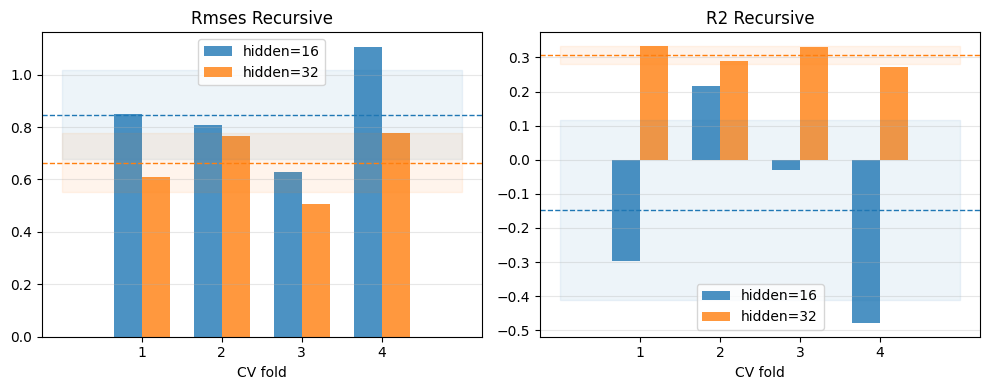

In [93]:

def plot_cv_comparison(results_a, results_b, label_a="model A", label_b="model B",
                       metrics=("rmses_recursive", "r2_recursive")):
    """
    results_*: dict-like with keys matching metrics and values = list/array per-fold.
               e.g. {'rmses_recursive': rmses_cv_at, 'r2_recursive': r2s_cv_at, ...}
    """
    n_metrics = len(metrics)
    fig, axes = plt.subplots(1, n_metrics, figsize=(5*n_metrics, 4))
    if n_metrics == 1:
        axes = [axes]

    for ax, metric in zip(axes, metrics):
        a = np.asarray(results_a[metric])
        b = np.asarray(results_b[metric])
        folds = np.arange(1, max(len(a), len(b)) + 1)

        # per-fold bars (align lengths)
        width = 0.35
        ax.bar(folds - width/2, a, width=width, label=label_a, alpha=0.8)
        ax.bar(folds + width/2, b, width=width, label=label_b, alpha=0.8)

        # mean ± std lines
        a_mean, a_std = np.nanmean(a), np.nanstd(a)
        b_mean, b_std = np.nanmean(b), np.nanstd(b)
        ax.axhline(a_mean, color='C0', linestyle='--', linewidth=1)
        ax.fill_between([0, folds[-1]+1], a_mean - a_std, a_mean + a_std, color='C0', alpha=0.08)
        ax.axhline(b_mean, color='C1', linestyle='--', linewidth=1)
        ax.fill_between([0, folds[-1]+1], b_mean - b_std, b_mean + b_std, color='C1', alpha=0.08)

        ax.set_xlabel("CV fold")
        ax.set_xticks(folds)
        ax.set_title(metric.replace("_", " ").title())
        ax.legend()
        ax.grid(axis='y', alpha=0.3)

    plt.tight_layout()
    plt.show()

# Build result dicts from your CV outputs (example using existing names)
results1 = {
    "rmses_recursive": rmses_cv_at,
    "r2_recursive": r2s_cv_at,
}
results2 = {
    "rmses_recursive": rmses_cv_at2,
    "r2_recursive": r2s_cv_at2,
}

# Plot
plot_cv_comparison(results1, results2, label_a="hidden=16", label_b="hidden=32")


In [85]:
model_at = build_autoregressive_model_lstm(train_X_ts_at, train_day_feat_X, train_static_X_ts, lag_n, hidden_unit = 32)
history_at = model_at.fit(
    train_ds_at,
    epochs=50,
    validation_data=val_ds_at,
)


Epoch 1/50


236/236 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - loss: 0.1750 - mae: 0.2758 - rmse: 0.4073 - val_loss: 0.0644 - val_mae: 0.1612 - val_rmse: 0.2380
Epoch 2/50
236/236 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0736 - mae: 0.1627 - rmse: 0.2584 - val_loss: 0.0485 - val_mae: 0.1328 - val_rmse: 0.2062
Epoch 3/50
236/236 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0617 - mae: 0.1437 - rmse: 0.2375 - val_loss: 0.0454 - val_mae: 0.1284 - val_rmse: 0.2016
Epoch 4/50
236/236 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0572 - mae: 0.1370 - rmse: 0.2299 - val_loss: 0.0414 - val_mae: 0.1229 - val_rmse: 0.1938
Epoch 5/50
236/236 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0543 - mae: 0.1325 - rmse: 0.2251 - val_loss: 0.0416 - val_mae: 0.1274 - val_rmse: 0.1959
Epoch 6/50
236/236 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0524 - mae: 0.1310 - rmse: 0.2223 - val_loss: 0.0390 - val_mae: 0.1165 - val_rmse: 0.1905
Epoch 7/50
236/236 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0502 - mae: 0.1269 - rmse: 0.2182 - v

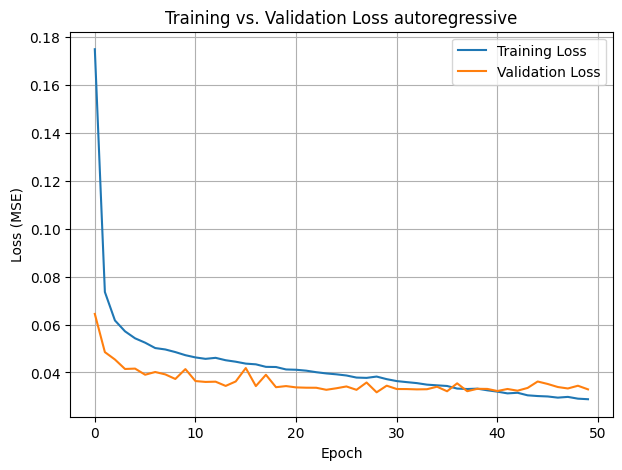

51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
rmse: 0.179345, r2: 0.947494 


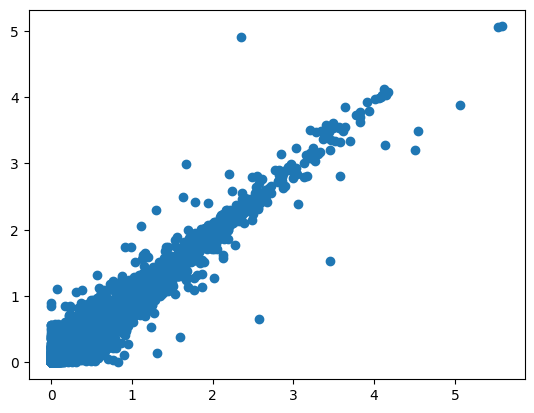

In [86]:


# Extract loss values
train_loss_at= history_at.history["loss"]
val_loss_at = history_at.history["val_loss"]

# Plot
plt.figure(figsize=(7, 5))
plt.plot(train_loss_at, label="Training Loss")
plt.plot(val_loss_at, label="Validation Loss")
plt.title("Training vs. Validation Loss autoregressive")
plt.xlabel("Epoch")
plt.ylabel("Loss (MSE)")
plt.legend()
plt.grid(True)
plt.show()




y_pred_val_1day_at= model_at.predict(val_ds_at)# show first few predictions

rmse_1day_at = root_mean_squared_error(y_pred_val_1day_at, val_y_at)
r2_1day_at = r2_score(val_y_at, y_pred_val_1day_at)
print(f'rmse: {rmse_1day_at:3f}, r2: {r2_1day_at:3f} ')
plt.scatter(val_y_at, y_pred_val_1day_at)

In [87]:
#sanity check on the newly built function with ridge regression, the prediction is the same from the other function
y_pred_val_at, y_val_at = compute_recursive_predictions_fast_LSTM(model_at, val_df_at, feature_window_size=lag_n,
label_window_size=1, shift=1, config=config, batch_size=64)

In [88]:
r2_at = r2_score(y_val_at, y_pred_val_at)
rmse_at = root_mean_squared_error(y_val_at, y_pred_val_at)

print(f"r2: {r2_score(y_val_at, y_pred_val_at)}\n rmse: {root_mean_squared_error(y_val_at, y_pred_val_at)}")

r2: 0.5854998713778115
 rmse: 0.5152066454294795


104/236 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step

/tmp/ipykernel_5576/713734198.py:18: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k--" (-> color='k'). The keyword argument will take precedence.
  ax1.plot(x_range, x_range, 'k--', lw=2, color="tab:orange")
/tmp/ipykernel_5576/713734198.py:19: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k--" (-> color='k'). The keyword argument will take precedence.
  ax1.plot(x_range, [i+rmse_at for i in x_range], 'k--', lw=2, color="gold")
/tmp/ipykernel_5576/713734198.py:20: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k--" (-> color='k'). The keyword argument will take precedence.
  ax1.plot(x_range, [i-rmse_at for i in x_range], 'k--', lw=2, color="gold")


236/236 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


/tmp/ipykernel_5576/713734198.py:55: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k--" (-> color='k'). The keyword argument will take precedence.
  ax4.plot(x_range, x_range, 'k--', lw=2, color="tab:orange")
/tmp/ipykernel_5576/713734198.py:56: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k--" (-> color='k'). The keyword argument will take precedence.
  ax4.plot(x_range, [i+rmse_1day for i in x_range], 'k--', lw=2, color="gold")
/tmp/ipykernel_5576/713734198.py:57: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k--" (-> color='k'). The keyword argument will take precedence.
  ax4.plot(x_range, [i-rmse_1day for i in x_range], 'k--', lw=2, color="gold")
/tmp/ipykernel_5576/713734198.py:70: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k--" (-> color='k'). The keyword argument will take precedence.


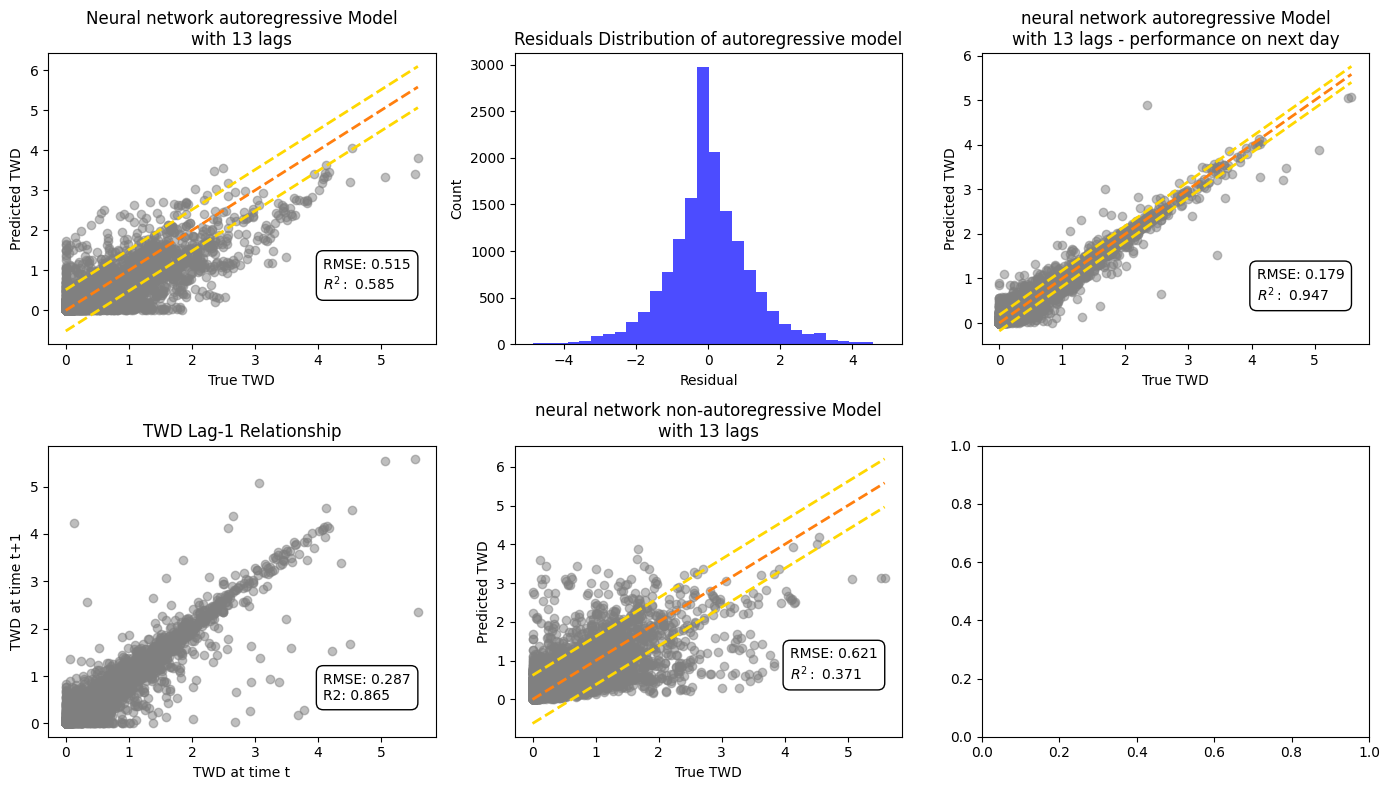

In [89]:
# Create figure with 3 subplots arranged in 1 row and 3 columns

def ensure_numpy(x):
    if isinstance(x, tf.Tensor):
        return x.numpy()
    return np.asarray(x)
val_y_at = ensure_numpy(val_y_at).reshape(-1)
y_pred_val_at = ensure_numpy(y_pred_val_at).reshape(-1)
val_y = ensure_numpy(val_y)

fig, ((ax1, ax2, ax5), (ax3, ax4, _)) = plt.subplots(2, 3, figsize=(14, 8))

# First subplot - Autoregressive Model Predictions
ax1.scatter(x=y_val_at, y=y_pred_val_at, color="grey", alpha=0.5)
ax1.set_xlabel("True TWD")
ax1.set_ylabel("Predicted TWD")
x_range = [val_y_at.min(), val_y_at.max()]
ax1.plot(x_range, x_range, 'k--', lw=2, color="tab:orange")
ax1.plot(x_range, [i+rmse_at for i in x_range], 'k--', lw=2, color="gold")
ax1.plot(x_range, [i-rmse_at for i in x_range], 'k--', lw=2, color="gold")
ax1.set_title(f"Neural network autoregressive Model\nwith {lag_n} lags")
ax1.text(val_y_at.max()-1.5,y_pred_val_at.min()+0.5, 
         f"RMSE: {rmse_at:.3f}\n$R^2:$ {r2_at:.3f}", 
         fontsize=10, bbox=dict(facecolor='white', edgecolor='black', boxstyle='round,pad=0.5'))


# Second subplot - Residuals histogram
y_res = train_y_at - model_at.predict(train_ds_at).reshape(-1)
ax2.hist(y_res, bins=30, color='blue', alpha=0.7)
ax2.set_xlabel("Residual")
ax2.set_ylabel("Count")
ax2.set_title("Residuals Distribution of autoregressive model")



# Third subplot - Lag-1 TWD relationship
rmse_lag1 = root_mean_squared_error(val_df["twd"][:-1], val_df['twd'][1:])
r2_score_lag1 = r2_score(val_df["twd"][:-1], val_df['twd'][1:])

ax3.scatter(val_df["twd"][:-1], val_df['twd'][1:], color='tab:grey', alpha=0.5)
ax3.set_xlabel("TWD at time t")
ax3.set_ylabel("TWD at time t+1")
ax3.set_title("TWD Lag-1 Relationship")
ax3.text(val_df["twd"][:-1].max()-1.5, val_df['twd'][1:].min()+0.5, 
         f"RMSE: {rmse_lag1:.3f}\nR2: {r2_score_lag1:.3f}", 
         fontsize=10, bbox=dict(facecolor='white', edgecolor='black', boxstyle='round,pad=0.5'))



# fourth subplot - non-Autoregressive Model Predictions
ax4.scatter(x=val_y, y=y_pred_val_1day.reshape(-1), color="grey", alpha=0.5)
ax4.set_xlabel("True TWD")
ax4.set_ylabel("Predicted TWD")
x_range = [val_y.min(), val_y.max()]
ax4.plot(x_range, x_range, 'k--', lw=2, color="tab:orange")
ax4.plot(x_range, [i+rmse_1day for i in x_range], 'k--', lw=2, color="gold")
ax4.plot(x_range, [i-rmse_1day for i in x_range], 'k--', lw=2, color="gold")
ax4.set_title(f"neural network non-autoregressive Model\nwith {lag_n} lags")
ax4.text(val_y.max()-1.5,y_pred_val_1day.min()+0.5, 
         f"RMSE: {rmse_1day:.3f}\n$R^2:$ {r2_1day:.3f}", 
         fontsize=10, bbox=dict(facecolor='white', edgecolor='black', boxstyle='round,pad=0.5'))



# fourth subplot - non-Autoregressive Model Predictions
ax5.scatter(x=val_y_at, y=y_pred_val_1day_at.reshape(-1), color="grey", alpha=0.5)
ax5.set_xlabel("True TWD")
ax5.set_ylabel("Predicted TWD")
x_range = [val_y_at.min(), val_y_at.max()]
ax5.plot(x_range, x_range, 'k--', lw=2, color="tab:orange")
ax5.plot(x_range, [i+rmse_1day_at for i in x_range], 'k--', lw=2, color="gold")
ax5.plot(x_range, [i-rmse_1day_at for i in x_range], 'k--', lw=2, color="gold")
ax5.set_title(f"neural network autoregressive Model\nwith {lag_n} lags - performance on next day")
ax5.text(val_y_at.max()-1.5,y_pred_val_1day_at.min()+0.5, 
         f"RMSE: {rmse_1day_at:.3f}\n$R^2:$ {r2_1day_at:.3f}", 
         fontsize=10, bbox=dict(facecolor='white', edgecolor='black', boxstyle='round,pad=0.5'))







# Adjust layout to prevent overlap
plt.tight_layout()
plt.show()

In [29]:
# create cross validation function to improve model robustness, otherwise i am just overfitting the same validation set 


to improve the model performance
- we can try to improve the LSTM architecture 
    -  added softplus - why it lowered the performance? 
    - play with the architecture and hyperparameter
- add also compute the correlation matrix of lagged features with twd
- should I create cross-validation function to choose the tune the model?
- how can i integrate autoregressive training?
- incorporate log value into traning 
- stack layers? 
- how to extrapolate if i use location and other static parameters in the future?
- perturbation to analyze feature importance